# Welcome to the $trans^2$ homework!

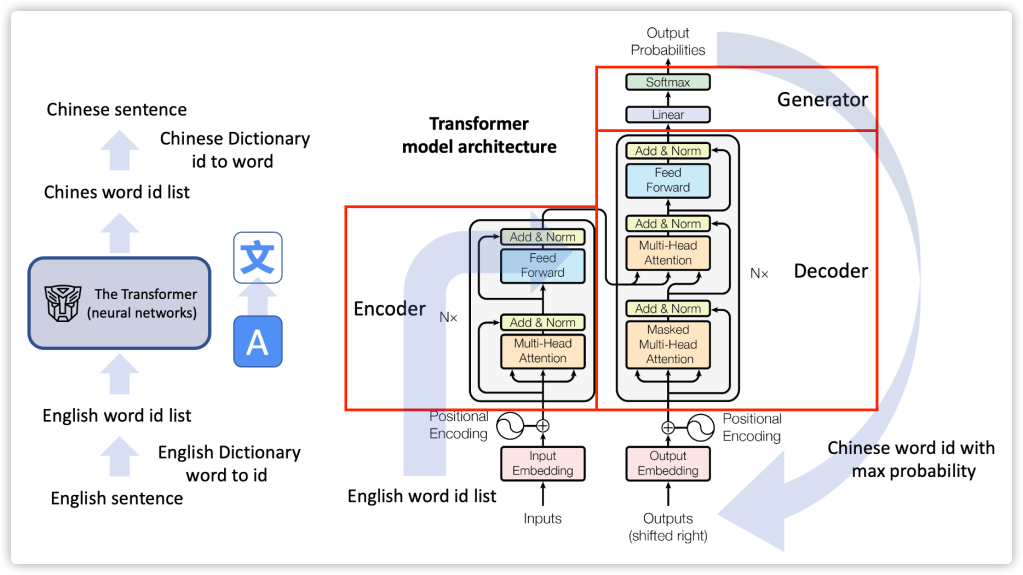

> This assignment based on this [online tutorial](https://cuicaihao.com/the-annotated-transformer-english-to-chinese-translator/)

# Part 1: English to Mandarin translation transformer ($trans^2$) model

## Retrive Data and Pre-trained Models

For this part, we will be using data from [this GitHub repo](https://github.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/tree/master/data/nmt/en-cn), it contains a training dataset (`train.txt`), validation dataset (`dev.txt`), and testing dataset (`test.txt`).

In [8]:
!mkdir -p data
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/train.txt -O data/train.txt
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/dev.txt -O data/dev.txt
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/test.txt -O data/test.txt
# The mini files are for debugging, feel free to comment out if you are not using it
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/train_mini.txt -O data/train_mini.txt
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/dev_mini.txt -O data/dev_mini.txt
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/test_mini.txt -O data/test_mini.txt

--2025-04-26 21:30:47--  https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
200 OKequest sent, awaiting response... 
Length: 915969 (895K) [text/plain]
Saving to: ‘data/train.txt’

data/train.txt      100%[===================>] 894.50K  --.-KB/s    in 0.06s   

2025-04-26 21:30:47 (13.8 MB/s) - ‘data/train.txt’ saved [915969/915969]

--2025-04-26 21:30:47--  https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

In [9]:
!mkdir -p pretrainedmodels
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/save/models/large_model.pt -O pretrainedmodels/large_model.pt
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/save/models/model.pt -O pretrainedmodels/model.pt

--2025-04-26 21:33:15--  https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/save/models/large_model.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
200 OKequest sent, awaiting response... 
Length: 66723029 (64M) [application/octet-stream]
Saving to: ‘pretrainedmodels/large_model.pt’

pretrainedmodels/la 100%[===================>]  63.63M  90.6MB/s    in 0.7s    

2025-04-26 21:33:18 (90.6 MB/s) - ‘pretrainedmodels/large_model.pt’ saved [66723029/66723029]

--2025-04-26 21:33:18--  https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/save/models/model.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecti

In [3]:
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk import word_tokenize
from collections import Counter
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt

# init parameters
UNK = 0  # unknow word-id
PAD = 1  # padding word-id
BATCH_SIZE = 64  
 
DEBUG = True    # Debug / Learning Purposes. 
# DEBUG = False # Build the model, better with GPU CUDA enabled.
 
if DEBUG:        
    EPOCHS  = 2  
    LAYERS  = 3  
    H_NUM   = 8   
    D_MODEL = 128  
    D_FF    = 256     
    DROPOUT = 0.1  
    MAX_LENGTH = 60  
    TRAIN_FILE = 'data/train_mini.txt'  
    DEV_FILE   = 'data/dev_mini.txt'  
    SAVE_FILE  = 'save/models/model.pt'  
else:
    EPOCHS  = 20 
    LAYERS  = 6   
    H_NUM   = 8   
    D_MODEL = 256   
    D_FF    = 1024  
    DROPOUT = 0.1   
    MAX_LENGTH = 60 
    TRAIN_FILE = 'data/train.txt'  
    DEV_FILE   = 'data/dev.txt'  
    SAVE_FILE  = 'save/models/large_model.pt' 
 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")